# 分类分级优化

# Part 1: 检验预测结果是否一致

In [1]:
import pandas as pd
import numpy as np
import datatable as dt
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [2]:
# 设置绘图时支持中文命名标题
font_path = '/System/Library/Fonts/STHeiti Medium.ttc'
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = prop.get_name()

# 设置默认的图像分辨率为300dpi
plt.rcParams['figure.dpi'] = 100

In [3]:
# 导入模型预测结果表和厂商分类分级结果表
df1 = dt.fread('/Users/suding/Desktop/分类分级优化/厂商模型结果.csv')
df2 = dt.fread('/Users/suding/Desktop/分类分级优化/模型预测结果.csv')
df1_pd = df1.to_pandas()
df2_pd = df2.to_pandas()
print(df1_pd.columns)
print(df2_pd.columns)

Index(['TABLE_ID', 'COLUMN_ID', 'STATUTE_NAME', 'NAME'], dtype='object')
Index(['SCHEMA_ID', 'TABLE_ID', 'COLUMN_ID', 'CN_TABLE_NAME', 'EN_TABLE_NAME',
       'CN_FIELD_NAME', 'EN_FIELD_NAME', 'SYSTEM_NAME', 'DATA_SOURCE_ID',
       'text', 'y_pred', 'load_time'],
      dtype='object')


In [4]:
# 进行模型结果匹配，仅考虑主键匹配一致的结果
def read_raw_data(path1, path2):  
    # 读取CSV文件
    df1 = dt.fread(path1)
    df2 = dt.fread(path2)
    
    # 主键转为大写后连接
    df1_pd = df1.to_pandas()
    df2_pd = df2.to_pandas()
    df1_pd[['TABLE_ID', 'COLUMN_ID']] = df1_pd[['TABLE_ID', 'COLUMN_ID']].apply(lambda x: x.str.upper())
    df2_pd[['TABLE_ID', 'COLUMN_ID']] = df2_pd[['TABLE_ID', 'COLUMN_ID']].apply(lambda x: x.str.upper())
    
    # 检查两个数据集的预测结果
    df = pd.merge(df1_pd, df2_pd, how='inner', on=['TABLE_ID', 'COLUMN_ID'])
    df['是否匹配'] = df.apply(lambda row: 1 if row['NAME'] == row['y_pred'] else (0 if pd.notna(row['NAME']) and pd.notna(row['y_pred']) else '未匹配成功'), axis=1)
    df.to_csv('/Users/suding/Desktop/分类分级优化/匹配结果.csv', index = False)
    
    return df

In [5]:
df_join = read_raw_data('/Users/suding/Desktop/分类分级优化/厂商模型结果.csv', '/Users/suding/Desktop/分类分级优化/模型预测结果.csv')

In [6]:
# 检查column_id & table_id均匹配成功
unmatched_df = df_join[df_join['是否匹配'] == '未匹配成功']
if len(unmatched_df) > 0:
    print("存在未匹配成功的情况:")
    print(unmatched_df)
else:
    print("所有结果均匹配成功")

所有结果均匹配成功


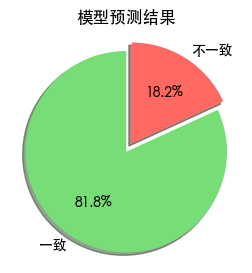

In [7]:
# 可视化匹配结果
match_counts = df_join['是否匹配'].value_counts()
labels = ['一致', '不一致']
sizes = [match_counts[1], match_counts[0]]
colors = ['#77DD77', '#FF6961']
explode = (0.1, 0) 

# 设置图像尺寸
fig, ax = plt.subplots(figsize=(3, 3))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  
plt.title('模型预测结果')

# 显示图像
plt.show()

In [8]:
# 再次检查TABLE_ID、COLUMN_ID中包含的表名、字段名是否与EN_TABLE_NAME、EN_FIELD_NAME一致
def compare_table_and_column_names(df):
    # 提取ID中最后一个字段（即表名、字段名）并统一为大写
    def extract_name(id):
        parts = id.split("--")
        if len(parts) > 1:
            return parts[-1].upper()
        else:
            return np.nan

    # 提取COLUMN_ID中的字段英文名和TABLE_ID中表英文名，并统一为大写
    df['Extracted_Table_Name'] = df['TABLE_ID'].apply(extract_name)
    df['Extracted_Column_Name'] = df['COLUMN_ID'].apply(extract_name)
    df['EN_TABLE_NAME'] = df['EN_TABLE_NAME'].str.upper()
    df['EN_FIELD_NAME'] = df['EN_FIELD_NAME'].str.upper()

    # 储存比对结果
    df['Table_Comparison_Result'] = np.where((df['Extracted_Table_Name'].isna()) | (df['EN_TABLE_NAME'].isna()), 
                                             '未匹配成功', 
                                             np.where(df['Extracted_Table_Name'] == df['EN_TABLE_NAME'], 1, 0))
    df['Column_Comparison_Result'] = np.where((df['Extracted_Column_Name'].isna()) | (df['EN_FIELD_NAME'].isna()), 
                                              '未匹配成功', 
                                              np.where(df['Extracted_Column_Name'] == df['EN_FIELD_NAME'], 1, 0))
    
    return df

In [9]:
# 比对结果可视化 (df_join为两数据集合并后的dataframe)
column_table_comparison = compare_table_and_column_names(df_join)

# 检查column_id & table_id均匹配成功
unmatched_df = df_join[df_join['Table_Comparison_Result'] == '未匹配成功']
if len(unmatched_df) > 0:
    print("存在未匹配成功的情况:")
    print(unmatched_df)
else:
    print("主键表名均匹配成功")
    
unmatched_df = df_join[df_join['Column_Comparison_Result'] == '未匹配成功']
if len(unmatched_df) > 0:
    print("存在未匹配成功的情况:")
    print(unmatched_df)
else:
    print("主键字段名均匹配成功")

主键表名均匹配成功
主键字段名均匹配成功


# Part 2: 提取预测一致的字段，选择概率最高的前10%

In [10]:
print(df_join.columns)

Index(['TABLE_ID', 'COLUMN_ID', 'STATUTE_NAME', 'NAME', 'SCHEMA_ID',
       'CN_TABLE_NAME', 'EN_TABLE_NAME', 'CN_FIELD_NAME', 'EN_FIELD_NAME',
       'SYSTEM_NAME', 'DATA_SOURCE_ID', 'text', 'y_pred', 'load_time', '是否匹配',
       'Extracted_Table_Name', 'Extracted_Column_Name',
       'Table_Comparison_Result', 'Column_Comparison_Result'],
      dtype='object')


In [11]:
# 选择出预测结果一致的所有字段
def select_matched_fields(df_join):
    selected_fields = ['CN_TABLE_NAME', 'EN_TABLE_NAME', 'CN_FIELD_NAME', 'EN_FIELD_NAME', 'SYSTEM_NAME', '是否匹配']
    selected_df = df_join[selected_fields]
    
    # 仅选择是否匹配字段为1的情况
    selected_df = selected_df[selected_df['是否匹配'] == 1]
    
    return selected_df

In [12]:
# 筛选出待新增预测概率的字段
selected_df = select_matched_fields(df_join)
selected_df.to_csv('/Users/suding/Desktop/分类分级优化/预测一致的数据集.csv', index = False)
print(selected_df.head(5))

  CN_TABLE_NAME                EN_TABLE_NAME CN_FIELD_NAME   EN_FIELD_NAME  \
0                ASSETS_COLLECTION_CASHFLOWS                       BALANCE   
1                ASSETS_COLLECTION_CASHFLOWS                COLLECTIONDATE   
2                ASSETS_COLLECTION_CASHFLOWS                        DEALID   
3                ASSETS_COLLECTION_CASHFLOWS                 DEFAULTAMOUNT   
4                ASSETS_COLLECTION_CASHFLOWS                            ID   

  SYSTEM_NAME  是否匹配  
0       大数据平台     1  
1       大数据平台     1  
2       大数据平台     1  
3       大数据平台     1  
4       大数据平台     1  


In [ ]:
pip install BayesianOptimization

In [ ]:
import zipfile
import os

import torch
import datetime
import time

import re
import nltk
import jieba
import pandas as pd
import torch.nn.functional as F
from nltk.corpus import stopwords
from model import TransferLearningBERT

In [ ]:
# 解压 punkt.zip 文件到 nltk_data/tokenizers 目录
with zipfile.ZipFile('punkt.zip', 'r') as zip_ref:
    zip_ref.extractall('nltk_data/tokenizers')

# 将 nltk_data 目录添加到 nltk 的数据路径
nltk.data.path.append("nltk_data")

In [ ]:
# 文本预处理部分：剔除停用词、特殊符号、数字、分词、文本向量编码
def read_preprocess_data(df):
    # df = pd.read_csv(filename, sep=r'\|-\|')
    df['text'] = df[['EN_TABLE_NAME', 'EN_FIELD_NAME', 'CN_TABLE_NAME', 'CN_FIELD_NAME', 'SYSTEM_NAME']].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
    df.dropna(subset=['text'], inplace=True)
    df['text'] = df['text'].str.lower()

    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    df['text'] = df['text'].apply(lambda x: re.sub(r'\s+', ' ', x))
    df['text'] = df['text'].apply(lambda x: x.strip())

    # 分词函数，用于对英文和中文进行分词
    def tokenize_text(text):
        # 分离中英文字符
        en_pattern = re.compile(r'[a-zA-Z]+')
        zh_pattern = re.compile(r'[\u4e00-\u9fa5]+')
        en_words = en_pattern.findall(text)
        zh_words = zh_pattern.findall(text)

        if len(en_words) > 0 and len(zh_words) > 0:
            en_tokens = nltk.word_tokenize(' '.join(en_words))
            zh_tokens = [w for w in jieba.cut(' '.join(zh_words)) if w.strip()]
            tokens = en_tokens + zh_tokens
        elif len(en_words) > 0:
            tokens = nltk.word_tokenize(text)
        else:
            tokens = [w for w in jieba.cut(text) if w.strip()]
        return ' '.join(tokens)

    # 对'text'列中的文本进行分词
    df['text'] = df['text'].apply(lambda x: tokenize_text(x))
    df['text'] = df['text'].apply(lambda x: x.replace('_', ' '))


    return df

In [72]:
# 载入所需预测数据集
pred_data = read_preprocess_data(selected_df)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/suding/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
print(pred_data.head(10))

  CN_TABLE_NAME                EN_TABLE_NAME CN_FIELD_NAME  \
0                ASSETS_COLLECTION_CASHFLOWS                 
1                ASSETS_COLLECTION_CASHFLOWS                 
2                ASSETS_COLLECTION_CASHFLOWS                 
3                ASSETS_COLLECTION_CASHFLOWS                 
4                ASSETS_COLLECTION_CASHFLOWS                 
5                ASSETS_COLLECTION_CASHFLOWS                 
6                ASSETS_COLLECTION_CASHFLOWS                 
7                ASSETS_COLLECTION_CASHFLOWS                 
8                ASSETS_COLLECTION_CASHFLOWS                 
9                ASSETS_COLLECTION_CASHFLOWS                 

             EN_FIELD_NAME SYSTEM_NAME  是否匹配  \
0                  BALANCE       大数据平台     1   
1           COLLECTIONDATE       大数据平台     1   
2                   DEALID       大数据平台     1   
3            DEFAULTAMOUNT       大数据平台     1   
4                       ID       大数据平台     1   
5           INTERESTAMOUNT   

In [74]:
# 进行对于“预测结果比对一致”的字段的概率计算，可基于内存自行选定batch_size大小
def predict_batch(texts, batch_size=1280):
    preds = []
    probs = []  # 创建一个新的空列表来存储每个标签的概率
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i: i+batch_size]

        encoded_dict = [model.tokenizer.encode_plus(text, add_special_tokens=True, max_length=128,
                                                    pad_to_max_length=True, return_attention_mask=True)
                        for text in batch_texts]

        input_ids = torch.tensor([enc['input_ids'] for enc in encoded_dict]).to(model.device)
        attention_masks = torch.tensor([enc['attention_mask'] for enc in encoded_dict]).to(model.device)

        with torch.no_grad():
            logits = model.model(input_ids, attention_mask=attention_masks)[0]

        predicted_labels = torch.argmax(logits, dim=1).cpu().numpy() + 1
        preds.extend(predicted_labels)
        
        # 使用 softmax 函数计算每个标签的概率
        softmax_probs = F.softmax(logits, dim=1).cpu().numpy()
        probs.extend(softmax_probs)  

    return preds, probs 

In [ ]:
# 加载模型
model = torch.load('complete_model.pt')
model.model.eval()

In [ ]:
# 对每一行进行预测并保存预测结果和时间戳
texts = pred_data['text'].tolist()
start_time = time.time()
y_preds, y_probs = predict_batch(texts) 
end_time = time.time()

load_time = datetime.datetime.fromtimestamp(end_time).strftime('%Y-%m-%d %H:%M:%S')  
pred_data['y_pred'] = y_preds
pred_data['load_time'] = load_time

# 将每个标签的概率添加到DataFrame中
pred_data['prob_1'] = [prob[0] for prob in y_probs]  # 添加级别为1的概率
pred_data['prob_2'] = [prob[1] for prob in y_probs]  # 添加级别为2的概率
pred_data['prob_3'] = [prob[2] for prob in y_probs]  # 添加级别为3的概率

pred_data.to_csv('/Users/suding/Desktop/分类分级优化/包含对应概率的预测结果.csv', index=False)

# Part 3: 提取预测结果不一致的字段，进行不确定性度量

In [13]:
# df_join：模型预测结果和厂商规则匹配结果连接后的dataframe
print(df_join.columns)

Index(['TABLE_ID', 'COLUMN_ID', 'STATUTE_NAME', 'NAME', 'SCHEMA_ID',
       'CN_TABLE_NAME', 'EN_TABLE_NAME', 'CN_FIELD_NAME', 'EN_FIELD_NAME',
       'SYSTEM_NAME', 'DATA_SOURCE_ID', 'text', 'y_pred', 'load_time', '是否匹配',
       'Extracted_Table_Name', 'Extracted_Column_Name',
       'Table_Comparison_Result', 'Column_Comparison_Result'],
      dtype='object')


In [14]:
# 选择出预测结果不一致的所有字段
def select_matched_fields(df_join):
    selected_fields = ['TABLE_ID', 'COLUMN_ID', 'CN_TABLE_NAME', 'EN_TABLE_NAME', 'CN_FIELD_NAME', 
                       'EN_FIELD_NAME', 'SYSTEM_NAME', '是否匹配']
    selected_df = df_join[selected_fields]
    
    # 仅选择是否匹配字段为0的情况
    selected_df = selected_df[selected_df['是否匹配'] == 0]
    
    return selected_df

In [15]:
# 筛选出待新增预测概率的字段
selected_df = select_matched_fields(df_join)
selected_df.to_csv('/Users/suding/Desktop/分类分级优化/预测不一致的数据集.csv', index = False)
print(selected_df.head(5))

                                              TABLE_ID  \
33   14289094079862AUJ1_CNABS--ABS_CN--ASSETS_PERFO...   
99             14289094079862AUJ1_CNABS--ABS_CN--BONDS   
100            14289094079862AUJ1_CNABS--ABS_CN--BONDS   
125  14289094079862AUJ1_CNABS--ABS_CN--BONDS_AMORTI...   
138  14289094079862AUJ1_CNABS--ABS_CN--BONDS_CASHFLOWS   

                                             COLUMN_ID CN_TABLE_NAME  \
33   14289094079862AUJ1_CNABS--ABS_CN--ASSETS_PERFO...                 
99   14289094079862AUJ1_CNABS--ABS_CN--BONDS--HASCR...                 
100        14289094079862AUJ1_CNABS--ABS_CN--BONDS--ID                 
125  14289094079862AUJ1_CNABS--ABS_CN--BONDS_AMORTI...                 
138  14289094079862AUJ1_CNABS--ABS_CN--BONDS_CASHFL...                 

           EN_TABLE_NAME CN_FIELD_NAME         EN_FIELD_NAME SYSTEM_NAME  是否匹配  
33    ASSETS_PERFORMANCE                             BALANCE       大数据平台     0  
99                 BONDS                HASCREDITENHANCE

In [58]:
# 可视化各系统中预测结果不一致的字段分布
def visualize_system_column_counts(dataframe, system_column='SYSTEM_NAME', column_id_column='COLUMN_ID', top_n=10):
    # 去除SYSTEM_NAME空值
    filtered_dataframe = dataframe.dropna(subset=[system_column])

    # 计算各系统不一致的字段的数量
    system_counts = filtered_dataframe.groupby(system_column)[column_id_column].nunique()
    top_systems = system_counts.nlargest(top_n)
    print(system_counts.nlargest(20))

    # 可视化
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
    
    axes[0].bar(top_systems.index, top_systems.values)
    #axes[0].set_xlabel(system_column)
    axes[0].set_ylabel('字段总数')
    axes[0].set_title('各系统不一致的字段总数 (Top {})'.format(top_n))
    axes[0].tick_params(axis='x', rotation=45) 

    axes[1].pie(top_systems.values, labels=top_systems.index, autopct='%1.1f%%')
    axes[1].set_title('各系统不一致的字段总数 (Top {})'.format(top_n))

    plt.tight_layout()
    plt.show()

SYSTEM_NAME
ODS系统               189388
大数据平台                19756
资产托管协作系统             18599
集中核算管理系统             15459
期货数据中心               15283
基金投顾后台系统             15093
机构客户管理系统(matrix)     13358
集中交易系统               12279
信用业务管理系统              9009
ADB系统                 8827
恒生投资监督系统              7904
卓沃绩效系统                7843
新意清算系统                7214
综合理财账户系统              5464
全渠道客服系统               5411
托管估值系统                5382
                      4476
OTC及TA系统              3583
外包估值系统                3572
投行智能数字化系统             3326
Name: COLUMN_ID, dtype: int64


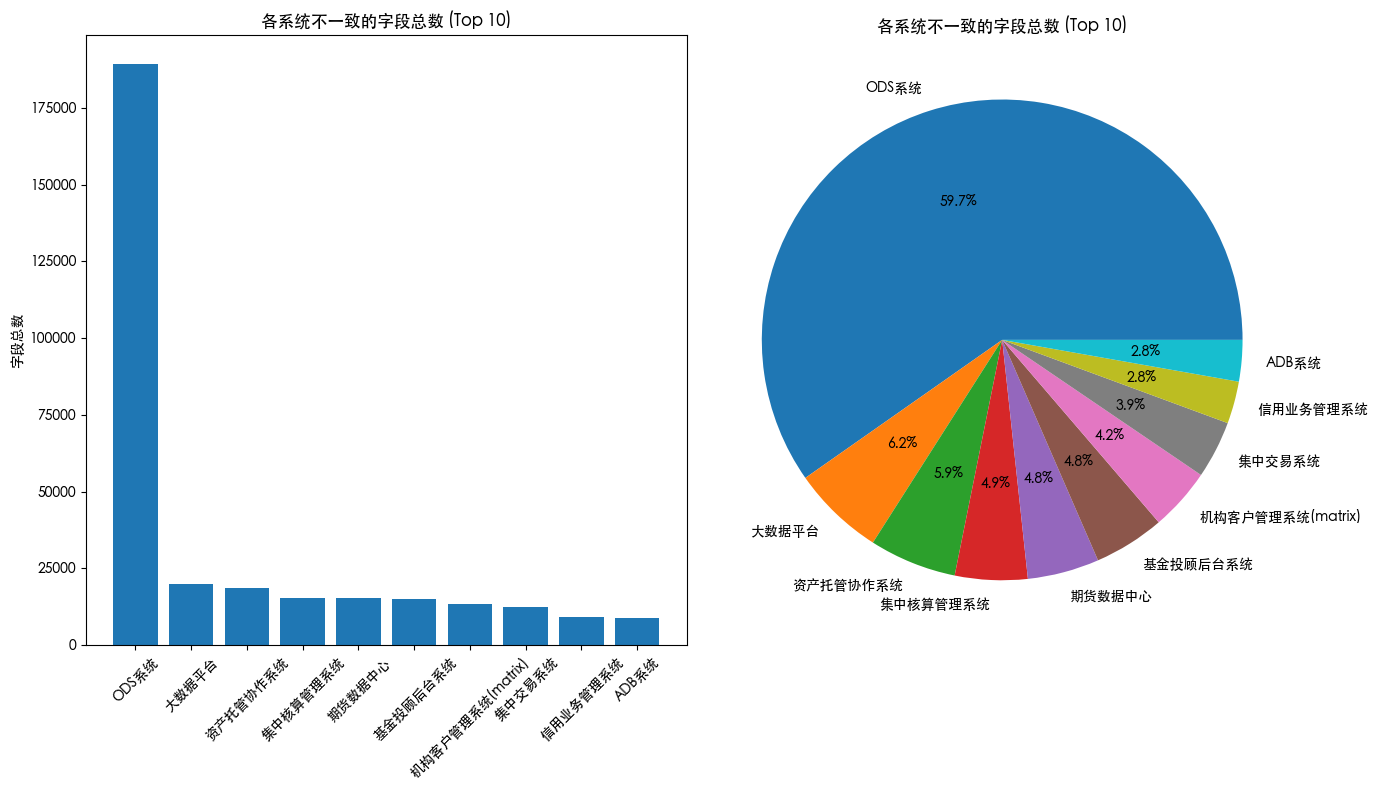

In [59]:
visualize_system_column_counts(selected_df)

注：出现不一致的潜在原因在于厂商打标的结果来自关键字匹配，若出现不匹配的情况会默认为2级。

# （1）不确定性度量 --- 最小置信度抽样

In [85]:
# 导入包含对应预测概率的数据集 --- '预测结果不一致的字段及对应概率.csv'
df_unequal_prob = dt.fread('/Users/suding/Desktop/分类分级优化/预测结果不一致的字段及对应概率.csv')
df_unequal_prob_pd = df_unequal_prob.to_pandas()

print(df_unequal_prob_pd.columns)

Index(['TABLE_ID', 'COLUMN_ID', 'CN_TABLE_NAME', 'EN_TABLE_NAME',
       'CN_FIELD_NAME', 'EN_FIELD_NAME', 'SYSTEM_NAME', '是否匹配', 'text',
       'y_pred', 'load_time', 'prob_1', 'prob_2', 'prob_3'],
      dtype='object')


In [86]:
def select_prob(df, percentage=0.1):
    # 根据y_pred字段选择对应的概率列(例：y_pred = 2，选择prob_2)
    prob_selected = df.apply(lambda x: x['prob_'+str(int(x['y_pred']))], axis=1)
    df['prob_selected'] = prob_selected
    
    # 选择概率最小的前10%的数据
    df = df.sort_values('prob_selected', ascending=True)
    n = int(len(df) * percentage)
    df_selected = df.iloc[:n]
    
    return df_selected

In [87]:
df_min_likelihood = select_prob(df_unequal_prob_pd, 0.1)

Number of rows:  42220


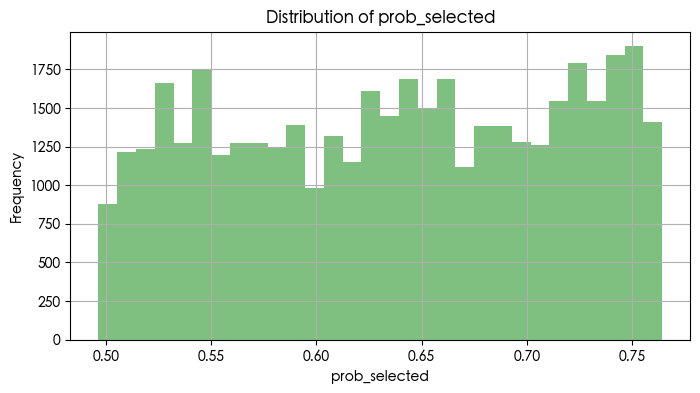

count    42220.000000
mean         0.637103
std          0.077536
min          0.496482
25%          0.568472
50%          0.640878
75%          0.706792
max          0.764290
Name: prob_selected, dtype: float64


In [88]:
# 输出筛选后数据集的行数
print("Number of rows: ", len(df_min_likelihood))

# 绘制prob_selected的直方图
plt.figure(figsize=(8, 4))
plt.hist(df_min_likelihood['prob_selected'], bins=30, alpha=0.5, color='g')
plt.xlabel('prob_selected')
plt.ylabel('Frequency')
plt.title('Distribution of prob_selected')
plt.grid(True)
plt.show()

# 使用describe()方法查看prob_selected的一些统计特性
print(df_min_likelihood['prob_selected'].describe())

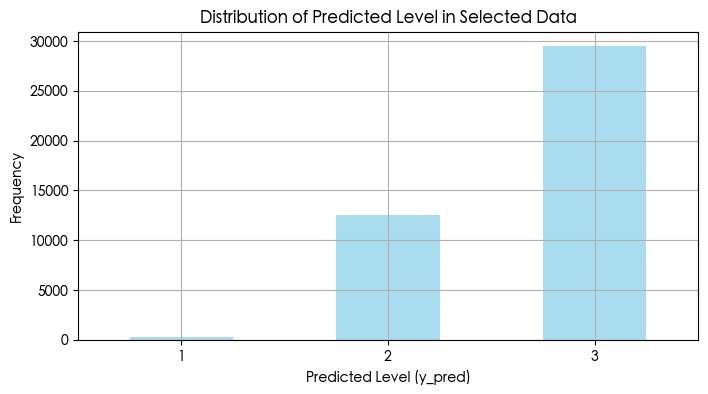

In [89]:
# 基于预测的等级可视化
df_min_likelihood['y_pred'].value_counts().sort_index().plot(kind='bar', color='skyblue', alpha=0.7, figsize=(8, 4))
plt.xlabel('Predicted Level (y_pred)')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Level in Selected Data')
plt.grid(True)
plt.tick_params(axis='x', rotation=0) 
plt.show()

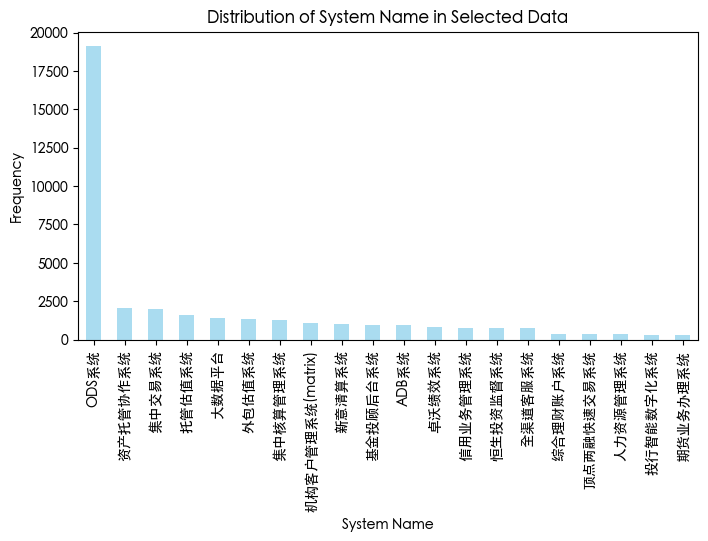

In [90]:
# 绘制system_name的分布
df_min_likelihood['SYSTEM_NAME'].value_counts().nlargest(20).plot(kind='bar', color='skyblue', alpha=0.7, figsize=(8, 4))
plt.xlabel('System Name')
plt.ylabel('Frequency')
plt.title('Distribution of System Name in Selected Data')
plt.tick_params(axis='x', rotation=90) 
plt.show()

In [91]:
# 保存第一种不确定性度量的结果至本地
df_min_likelihood.to_csv('/Users/suding/Desktop/分类分级优化/最小置信度结果.csv', index = False)

# （2）不确定性度量 --- 置信度抽样间距

In [92]:
# 导入包含对应预测概率的数据集 --- '预测结果不一致的字段及对应概率.csv'
df_unequal_prob = dt.fread('/Users/suding/Desktop/分类分级优化/预测结果不一致的字段及对应概率.csv')
df_unequal_prob_pd = df_unequal_prob.to_pandas()

print(df_unequal_prob_pd.columns)

Index(['TABLE_ID', 'COLUMN_ID', 'CN_TABLE_NAME', 'EN_TABLE_NAME',
       'CN_FIELD_NAME', 'EN_FIELD_NAME', 'SYSTEM_NAME', '是否匹配', 'text',
       'y_pred', 'load_time', 'prob_1', 'prob_2', 'prob_3'],
      dtype='object')


In [93]:
def select_min_diff(df, percentage=0.1):
    # 计算每条记录预测概率最大和次大的差值
    prob_cols = ['prob_1', 'prob_2', 'prob_3']
    df['prob_diff'] = df[prob_cols].apply(lambda row: row.nlargest(2).diff().abs().iloc[-1], axis=1)
    
    # 升序排列
    df = df.sort_values('prob_diff', ascending=True)
    
    # 选择概率差值最小的前10%的数据
    n = int(len(df) * percentage)
    df_selected = df.iloc[:n]
    
    return df_selected

In [94]:
df_interval_likelihood = select_min_diff(df_unequal_prob_pd, 0.1)

Number of rows:  42220


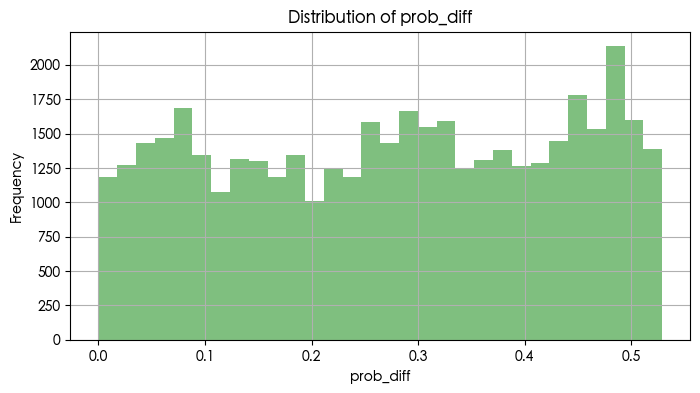

count    42220.000000
mean         0.274878
std          0.155016
min          0.000058
25%          0.137508
50%          0.282535
75%          0.414160
max          0.528974
Name: prob_diff, dtype: float64


In [95]:
# 输出筛选后数据集的行数
print("Number of rows: ", len(df_interval_likelihood))

# 绘制prob_selected的直方图
plt.figure(figsize=(8, 4))
plt.hist(df_interval_likelihood['prob_diff'], bins=30, alpha=0.5, color='g')
plt.xlabel('prob_diff')
plt.ylabel('Frequency')
plt.title('Distribution of prob_diff')
plt.grid(True)
plt.show()

# 使用describe()方法查看prob_selected的一些统计特性
print(df_interval_likelihood['prob_diff'].describe())

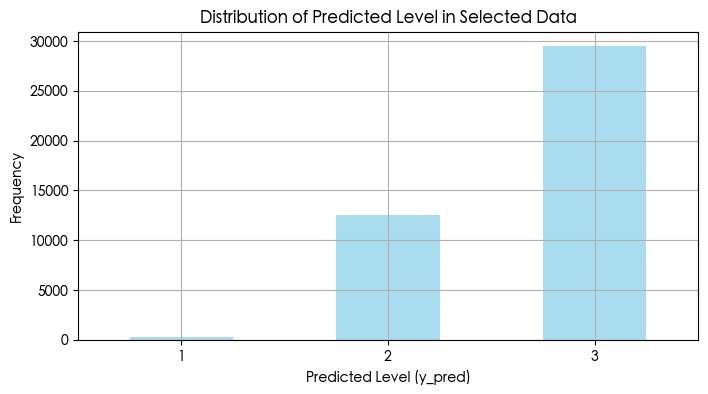

In [96]:
# 基于预测的等级可视化
df_interval_likelihood['y_pred'].value_counts().sort_index().plot(kind='bar', color='skyblue', alpha=0.7, figsize=(8, 4))
plt.xlabel('Predicted Level (y_pred)')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Level in Selected Data')
plt.grid(True)
plt.tick_params(axis='x', rotation=0) 
plt.show()

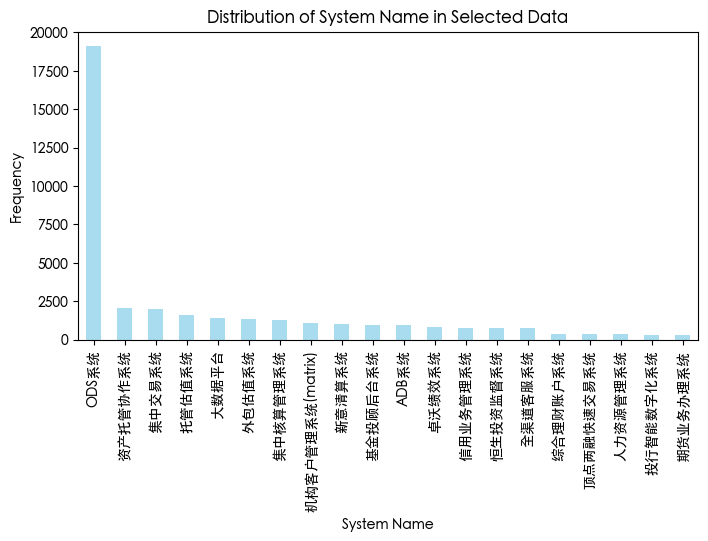

In [97]:
# 绘制system_name的分布
df_interval_likelihood['SYSTEM_NAME'].value_counts().nlargest(20).plot(kind='bar', color='skyblue', alpha=0.7, figsize=(8, 4))
plt.xlabel('System Name')
plt.ylabel('Frequency')
plt.title('Distribution of System Name in Selected Data')
plt.tick_params(axis='x', rotation=90) 
plt.show()

In [98]:
# 保存第二种不确定性度量的结果至本地
df_interval_likelihood.to_csv('/Users/suding/Desktop/分类分级优化/置信度抽样间距结果.csv', index = False)

# （3）不确定性度量 --- 熵抽样

In [99]:
# 导入包含对应预测概率的数据集 --- '预测结果不一致的字段及对应概率.csv'
df_unequal_prob = dt.fread('/Users/suding/Desktop/分类分级优化/预测结果不一致的字段及对应概率.csv')
df_unequal_prob_pd = df_unequal_prob.to_pandas()

print(df_unequal_prob_pd.columns)

Index(['TABLE_ID', 'COLUMN_ID', 'CN_TABLE_NAME', 'EN_TABLE_NAME',
       'CN_FIELD_NAME', 'EN_FIELD_NAME', 'SYSTEM_NAME', '是否匹配', 'text',
       'y_pred', 'load_time', 'prob_1', 'prob_2', 'prob_3'],
      dtype='object')


In [100]:
def calculate_entropy(df):
    # 计算每个text的熵
    prob_cols = ['prob_1', 'prob_2', 'prob_3']
    df['entropy'] = df[prob_cols].apply(lambda x: -np.sum(x*np.log2(x)), axis=1)
    return df

In [101]:
def select_max_entropy(df, percentage=0.1):
    # 降序排列
    df = df.sort_values('entropy', ascending=False)
    
    # 选择熵最大的前10%的数据
    n = int(len(df) * percentage)
    df_selected = df.iloc[:n]
    
    return df_selected

In [102]:
df_with_entropy = calculate_entropy(df_unequal_prob_pd)

In [103]:
df_selected_entropy = select_max_entropy(df_with_entropy, 0.1)

Number of rows:  42220


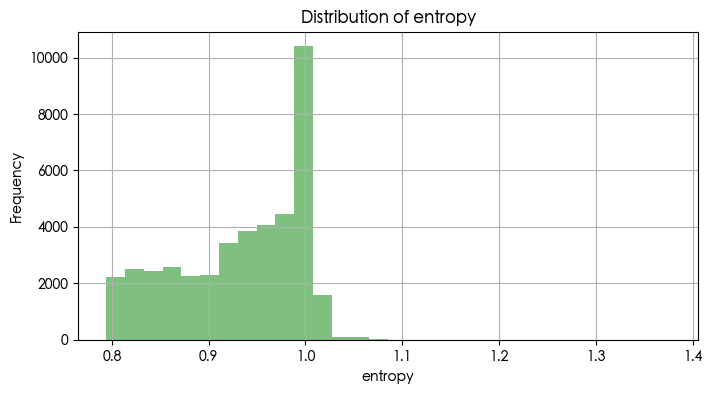

count    42220.000000
mean         0.932734
std          0.065750
min          0.794154
25%          0.879160
50%          0.946599
75%          0.993364
max          1.376433
Name: entropy, dtype: float64


In [104]:
# 输出筛选后数据集的行数
print("Number of rows: ", len(df_selected_entropy))

# 绘制entropy的直方图
plt.figure(figsize=(8, 4))
plt.hist(df_selected_entropy['entropy'], bins=30, alpha=0.5, color='g')
plt.xlabel('entropy')
plt.ylabel('Frequency')
plt.title('Distribution of entropy')
plt.grid(True)
plt.show()

# 使用describe()方法查看prob_selected的一些统计特性
print(df_selected_entropy['entropy'].describe())

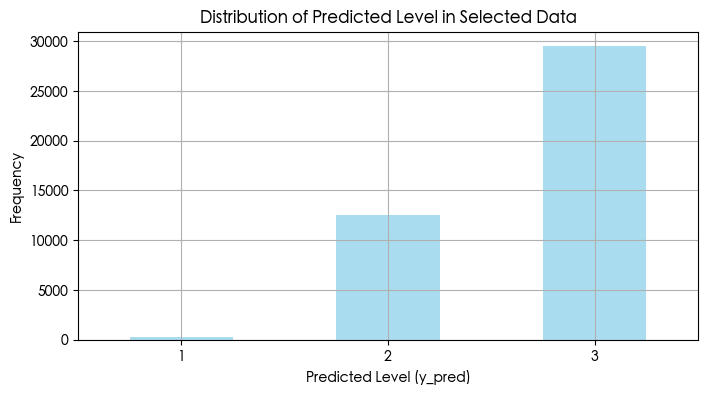

In [105]:
# 基于预测的等级可视化
df_selected_entropy['y_pred'].value_counts().sort_index().plot(kind='bar', color='skyblue', alpha=0.7, figsize=(8, 4))
plt.xlabel('Predicted Level (y_pred)')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Level in Selected Data')
plt.grid(True)
plt.tick_params(axis='x', rotation=0) 
plt.show()

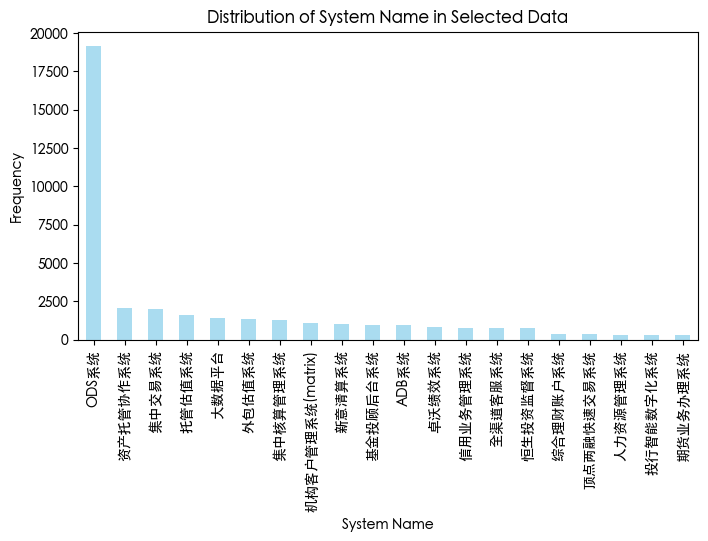

In [106]:
# 绘制system_name的分布
df_selected_entropy['SYSTEM_NAME'].value_counts().nlargest(20).plot(kind='bar', color='skyblue', alpha=0.7, figsize=(8, 4))
plt.xlabel('System Name')
plt.ylabel('Frequency')
plt.title('Distribution of System Name in Selected Data')
plt.tick_params(axis='x', rotation=90) 
plt.show()

In [107]:
# 保存第三种不确定性度量的结果至本地
df_selected_entropy.to_csv('/Users/suding/Desktop/分类分级优化/熵抽样结果.csv', index = False)

# （4）筛选出三种查询策略下均位于前10%的数据

In [119]:
# 合并这三个数据集，找出均位于前10%的数据
df_common = pd.merge(df_min_likelihood, df_interval_likelihood, on=['TABLE_ID', 'COLUMN_ID'])
df_common = pd.merge(df_common, df_selected_entropy, on=['TABLE_ID', 'COLUMN_ID'])

In [120]:
# 剔除重复字段
fields_needed = ['TABLE_ID', 'COLUMN_ID', 'CN_TABLE_NAME', 'EN_TABLE_NAME',
       'CN_FIELD_NAME', 'EN_FIELD_NAME', 'SYSTEM_NAME', '是否匹配', 'text',
       'y_pred']
df_common_selected = df_common[fields_needed]
print(df_common_selected.head(5))

                                            TABLE_ID  \
0            ZHLCHIS--HS_ACCT--GTJA_PREOFSTOCKHOLDER   
1  14289094079862AUJ1_JTSJJS--DE_SYHH--TCH_H_CRED...   
2                    ODS--SPSS--TCL_TB_OVERVIEW_RZRQ   
3                        JZQS--NODE--NODE_CLOSEORDER   
4  14289134843619U36K_RLZY--GTJA--ASHIFT_STATIST_ALL   

                                           COLUMN_ID     CN_TABLE_NAME  \
0  ZHLCHIS--HS_ACCT--GTJA_PREOFSTOCKHOLDER--DEGRE...                     
1  14289094079862AUJ1_JTSJJS--DE_SYHH--TCH_H_CRED...  客户互换合约历史备份(存续合约)   
2  ODS--SPSS--TCL_TB_OVERVIEW_RZRQ--MKT_BALANCE_R...                     
3            JZQS--NODE--NODE_CLOSEORDER--TOTALDEBTS                     
4  14289134843619U36K_RLZY--GTJA--ASHIFT_STATIST_...                     

           EN_TABLE_NAME CN_FIELD_NAME            EN_FIELD_NAME SYSTEM_NAME  \
0  GTJA_PREOFSTOCKHOLDER                            DEGREE_CODE    综合理财账户系统   
1  TCH_H_CREDITDEBTS_BAK                           LASTPAYPR

共同数据集的大小： (42090, 10)


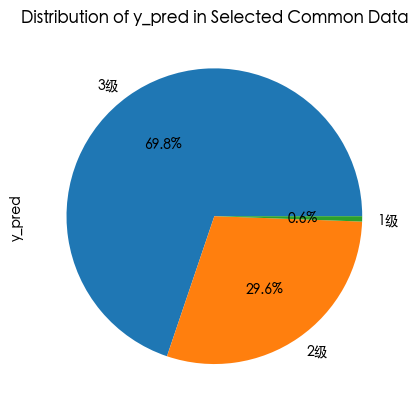

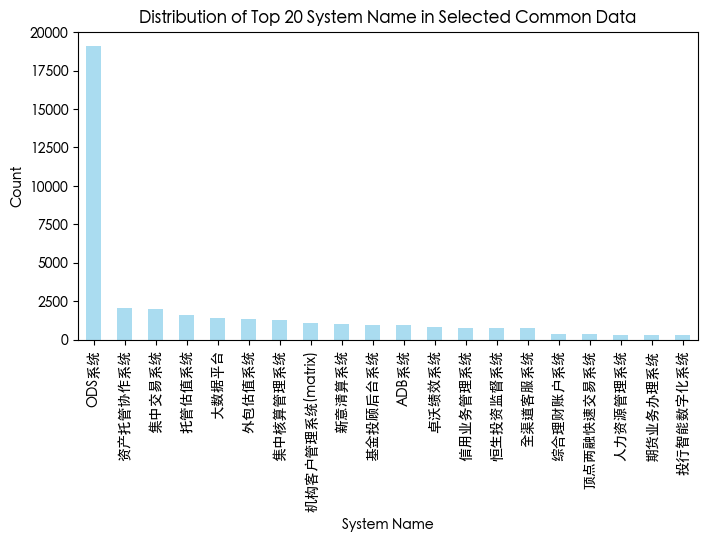

In [125]:
# 输出筛选后的数据集大小
print("共同数据集的大小：", df_common_selected.shape)

# 对y_pred进行饼图可视化
df_common_selected_copy = df_common_selected.copy()
df_common_selected_copy['y_pred'] = df_common_selected['y_pred'].apply(lambda x: str(x) + '级')
df_common_selected_copy['y_pred'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of y_pred in Selected Common Data')
plt.show()

# 对system_name进行可视化，仅对前20个进行可视化
df_common_selected['SYSTEM_NAME'].value_counts()[:20].plot(kind='bar', color='skyblue', alpha=0.7, figsize=(8, 4))
plt.xlabel('System Name')
plt.ylabel('Count')
plt.title('Distribution of Top 20 System Name in Selected Common Data')
plt.grid(False)
plt.show()

In [126]:
# 导出最终待筛选集
df_common_selected.to_csv('/Users/suding/Desktop/分类分级优化/比对结果不一致的待筛选集.csv', index = False)